# Fitting wells

This notebook introduces the concept of fitting wells and how they are used in `gwrefpy`. The methodology originates from the description by its author [Strandanger (2024)](https://svenskageotekniskaforeningen.se/wp-content/uploads/Publikationer/SGF_Rapporter/2024_2_Akvifars_refmetod.pdf).

This notebook can be downloaded from the source code [here](https://github.com/andersretznerSGU/gwrefpy/blob/main/docs/user_guide/2_fitting_wells.ipynb).

To analyse deviations in groundwater level timeseries, the `gwrefpy` methodology relies on observation wells and reference wells. To check for deviations in an observation well, we fit its data to a reference well using regression. When fitting the two wells, we specify a calibration period. If data outside of the calibration period does not follow the fitted regression, a deviation has occurred. 

In this notebook, we will dive deeper into the fitting workflow and showcase this library's associated capabilities.

```{note}
See [this notebook on wells](https://github.com/andersretznerSGU/gwrefpy/blob/main/docs/user_guide/2_fitting_wells.ipynb)
```


In [1]:
import gwrefpy as gr
import matplotlib.pyplot as plt
gr.set_log_level("ERROR")

## Data

In this notebook, we will work with data provided by `gwrefpy`. Let's load the model using its file name and plot the observation wells and reference wells separately.

In [2]:
model = gr.Model("small_example.gwref")
model.fits = []  # clear existing fits

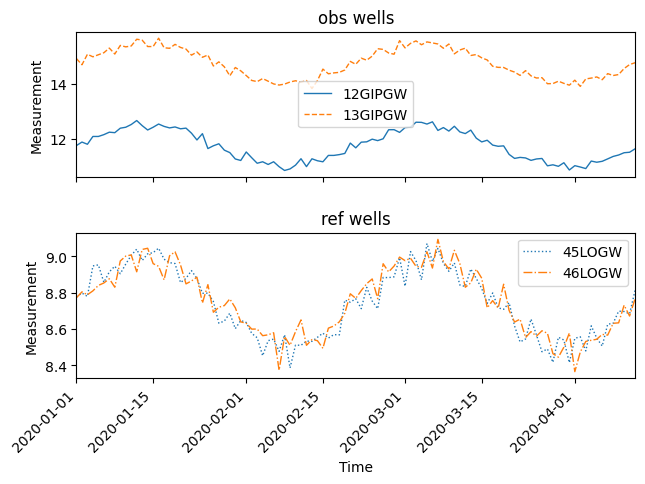

In [3]:
fig, (up, down) = plt.subplots(nrows=2, sharex=True)
model.plot_wells(model.obs_wells, ax=up)
model.plot_wells(model.ref_wells, ax=down)

up.set_title("obs wells")
down.set_title("ref wells")

up.legend()
down.legend()

fig.autofmt_xdate(rotation=45)

## Anatomy of a fit

Let's walk through the anatomy of a fit by fitting the observation well _12GIPGW_ to the reference well _45LOGW_. To fit wells within a model, we call `model.fit()` which has the following signature:

In [4]:
help(model.fit)

Help on method fit in module gwrefpy.fitbase:

fit(obs_well: gwrefpy.well.Well | list[gwrefpy.well.Well] | str | list[str], ref_well: gwrefpy.well.Well | list[gwrefpy.well.Well] | str | list[str], offset: pandas._libs.tslibs.offsets.DateOffset | pandas._libs.tslibs.timedeltas.Timedelta | str, aggregation: Literal['mean', 'median', 'min', 'max'] = 'mean', p: float = 0.95, method: Literal['linearregression'] = 'linearregression', tmin: pandas._libs.tslibs.timestamps.Timestamp | str | None = None, tmax: pandas._libs.tslibs.timestamps.Timestamp | str | None = None, report: bool = True) -> gwrefpy.fitresults.FitResultData | list[gwrefpy.fitresults.FitResultData] method of gwrefpy.model.Model instance
    Fit reference well(s) to observation well(s) using regression.
    
    Parameters
    ----------
    obs_well : Well | list[Well] | str | list[str]
        The observation well(s) to use for fitting. Can be Well objects,
        well names (strings), or lists of either. If a list is provid

The first two arguments determine which wells to use. 

The `offset` and `aggregation` arguments handle cases where the timeseries of the wells are not aligned, see [this notebook](). The wells in this model are sampled daily and cover the same period, which means we can use `"0D"` as the offset which also renders the `aggregation` argument obsolete.

The `p` argument controls which confidence level to use when evaluating the lower and upper bound from which to recognize deviations. We will use the default `p`-value of 0.05.

The `tmin` and `tmax` arguments control the period in which we want to perform the fit. This is an important decision that can only be inferred from prior knowledge of the wells. We want to select this period such that no (or negligble) external factors are affecting head in the observation well. In this example, we will assume that January through March accomplishes this.

```{important}
The reference well needs to be unaffected by external factors during its entire time period.
```

Currently, `gwrefpy` supports the linear regression fit as demonstrated in [Strandanger (2024)](https://svenskageotekniskaforeningen.se/wp-content/uploads/Publikationer/SGF_Rapporter/2024_2_Akvifars_refmetod.pdf), which is what we will cover in this notebook. Linear regression is currently the only available method, which is why we don't have to explicitly pass it.

TODO: include `tmin` and `tmax` as argument in the `.fit()` method so that they are visible as type hints

Let's do this!

In [5]:
model.fit(
    obs_well="12GIPGW",
    ref_well="45LOGW",
    offset="0D",
    tmin="2020-01-01",
    tmax="2020-03-01"
)

Statistic,Value,Description
RMSE,0.1752,Root Mean Square Error
R²,0.8849,Coefficient of Determination
R-value,0.9407,Correlation Coefficient
Slope,2.7211,Linear Regression Slope
Intercept,-12.0207,Linear Regression Intercept
P-value,0.0000,Statistical Significance
N,61,Number of Data Points
Std Error,0.1781,Standard Error
Confidence,95.0%,Confidence Level


By default when calling `fit()`, a summary of the fitted regression is displayed as seen above.

Calling `fit()` results in a `FitResultData` object being created and stored in the model instance's `fits` attribute. Let's plot the resulting fit to verify everything is OK. We use the `plot_fitmethod()` method and pass all available fits knowing it will only contain the fit we just created.

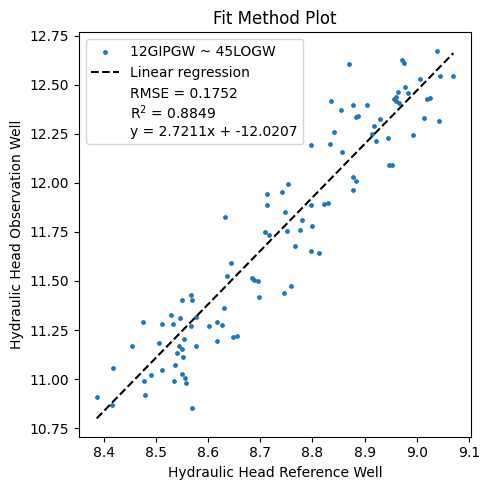

In [6]:
_ = model.plot_fitmethod(model.fits)


Everything looks reasonable and we can continue evaluating our data.

The fit was created using the first three months of data, and we can suspect that our observation well may be affected by external factors outside of this period. 

Evaluating this is a key `gwrefpy` feature! Below, we plot the resulting fit and transformed head, along with the lower and upper confidence limit based on our `p` value (0.05) and the fit.

TODO: lets not plot the reference well head by default, it skews the plot

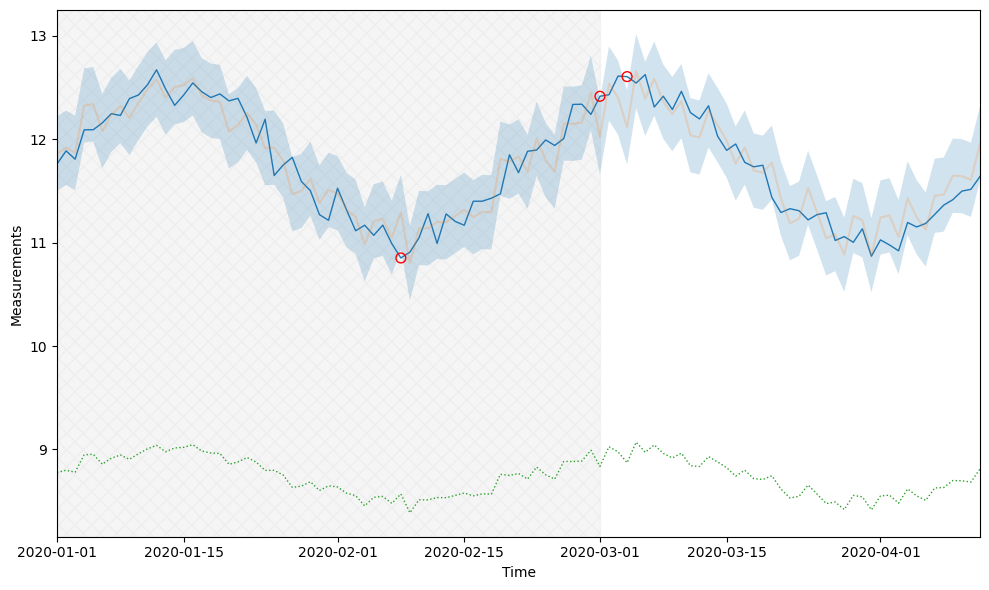

In [7]:
_ = model.plot_fits(show_initiation_period=True)